In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Load the data

In [29]:
df = pd.read_csv("train.csv")

# Data Information and Missing Values

In [30]:
df_info = df.info()
df_head = df.head()
df_missing = df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

# Clean the data
 ### Convert categorical text to numeric 

In [31]:
df_clean = df.copy()
df_clean['sex'] = df_clean['sex'].map({'M': 1, 'F': 0})
df_clean['is_smoking'] = df_clean['is_smoking'].map({'YES': 1, 'NO': 0})

### Impute missing values

In [32]:
for col in ['education', 'BPMeds']:
    mode_val = df_clean[col].mode()[0]
    df_clean[col] = df_clean[col].fillna(mode_val)

for col in ['cigsPerDay', 'totChol', 'BMI', 'glucose', 'heartRate']:
    median_val = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_val)

### Check missing values after cleaning

In [33]:
missing_after_cleaning = df_clean.isnull().sum().sort_values(ascending=False)

df_clean.head(), missing_after_cleaning

(   id  age  education  sex  is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
 0   0   64        2.0    0           1         3.0     0.0                0   
 1   1   36        4.0    1           0         0.0     0.0                0   
 2   2   46        1.0    0           1        10.0     0.0                0   
 3   3   50        1.0    1           1        20.0     0.0                0   
 4   4   64        1.0    0           1        30.0     0.0                0   
 
    prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
 0             0         0    221.0  148.0   85.0  25.38       90.0     80.0   
 1             1         0    212.0  168.0   98.0  29.77       72.0     75.0   
 2             0         0    250.0  116.0   71.0  20.35       88.0     94.0   
 3             1         0    233.0  158.0   88.0  28.26       68.0     94.0   
 4             0         0    241.0  136.5   85.0  26.42       70.0     77.0   
 
    TenYearCHD  
 0           1  
 1

# Exploratory Data Analysis (EDA)

### Correlation Matrix Plot

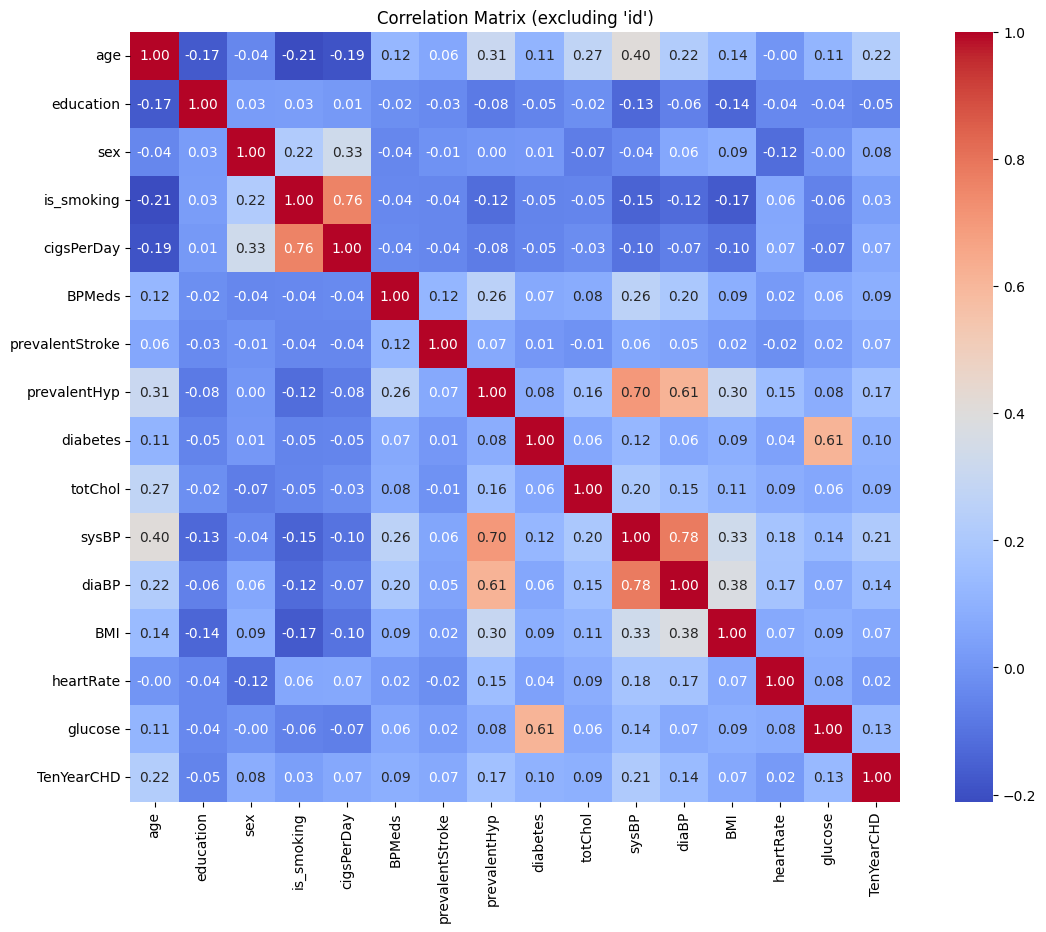

In [34]:
corr_matrix = df_clean.drop(columns=['id']).corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (excluding 'id')")
plt.show()

### Distribution of continuous variables

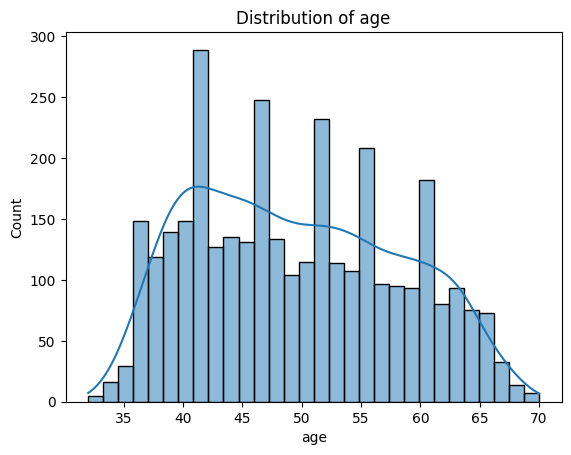

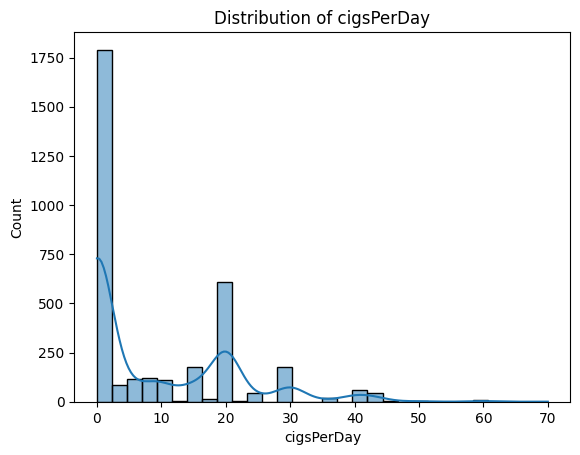

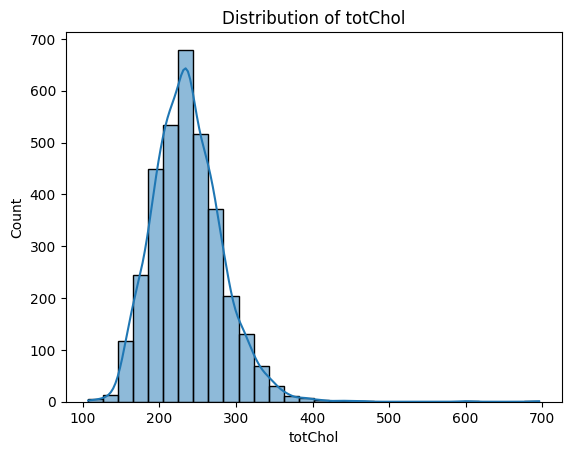

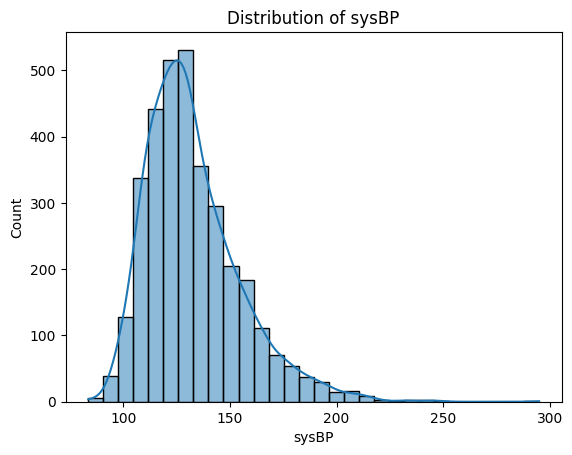

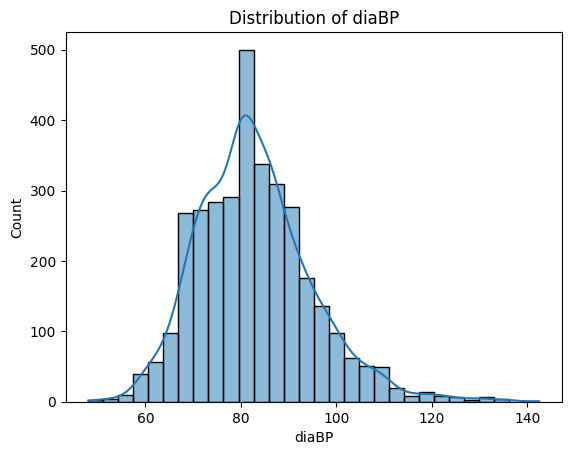

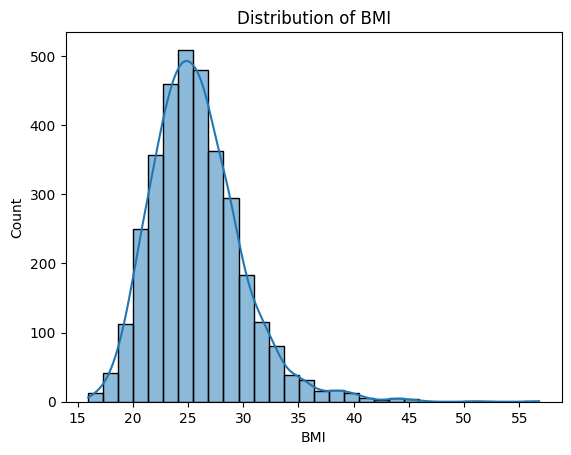

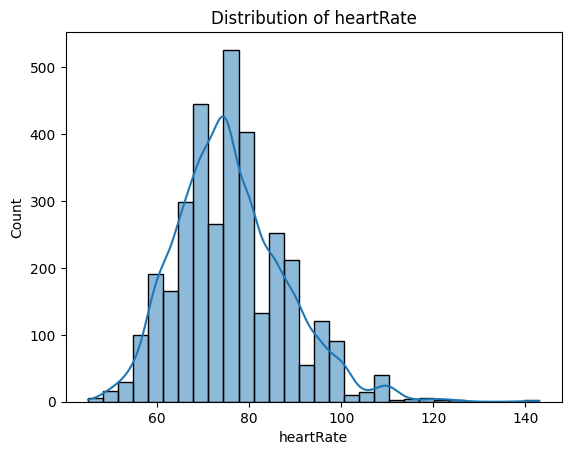

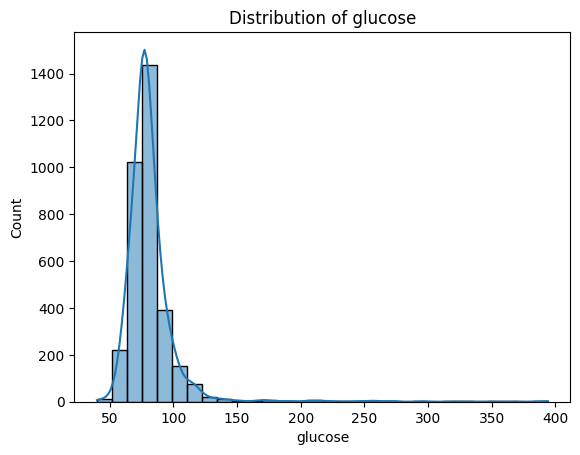

In [35]:
continuous_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for col in continuous_vars:
    plt.figure()
    sns.histplot(data=df_clean, x=col, kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

### CHD vs. Categorical Features

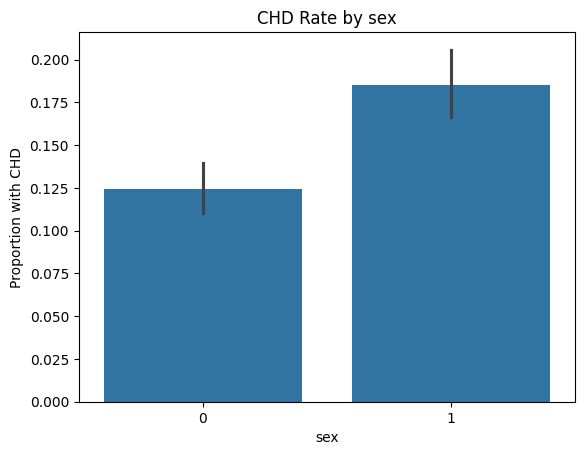

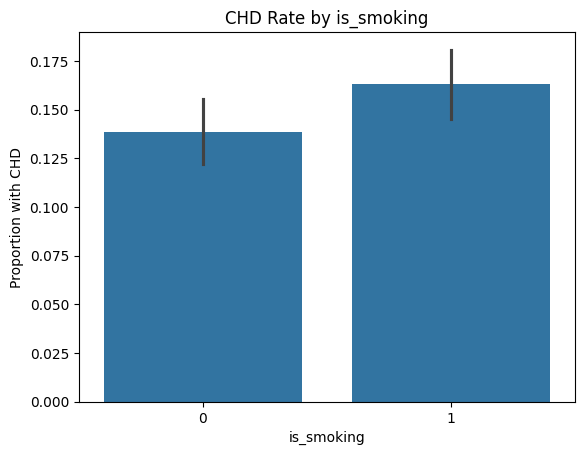

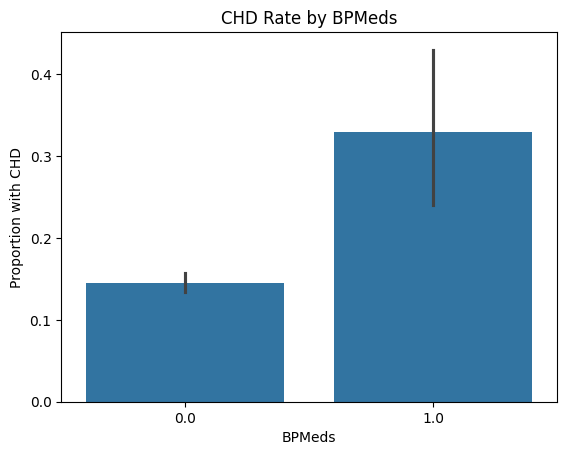

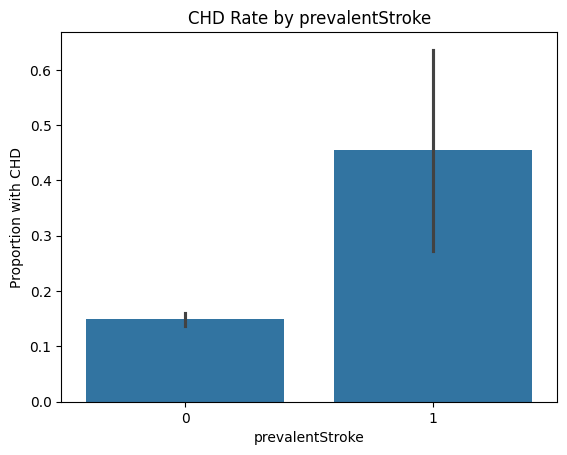

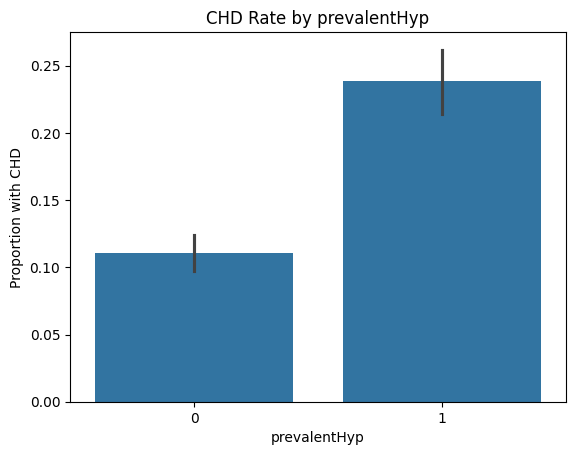

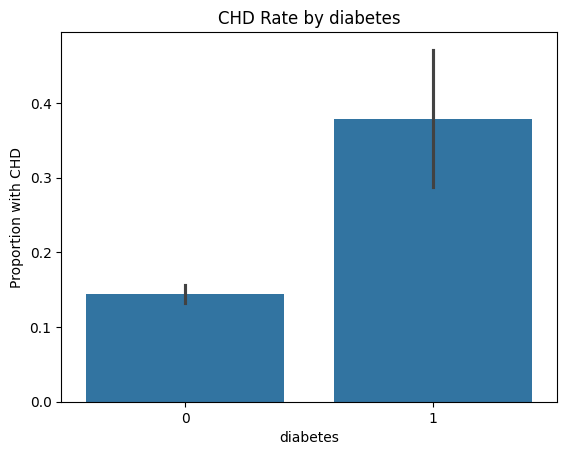

In [36]:
categorical_vars = ['sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
for col in categorical_vars:
    plt.figure()
    sns.barplot(x=col, y='TenYearCHD', data=df_clean)
    plt.title(f'CHD Rate by {col}')
    plt.ylabel('Proportion with CHD')
    plt.show()

### Boxplots: CHD Risk vs Continuous Variables

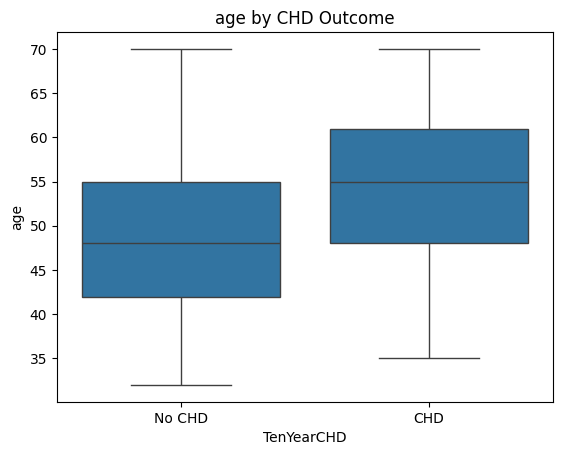

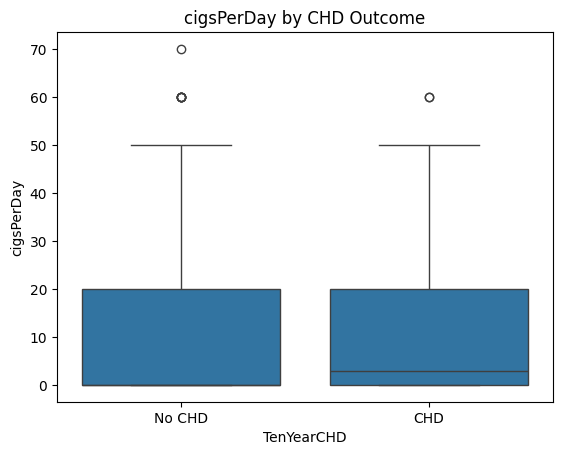

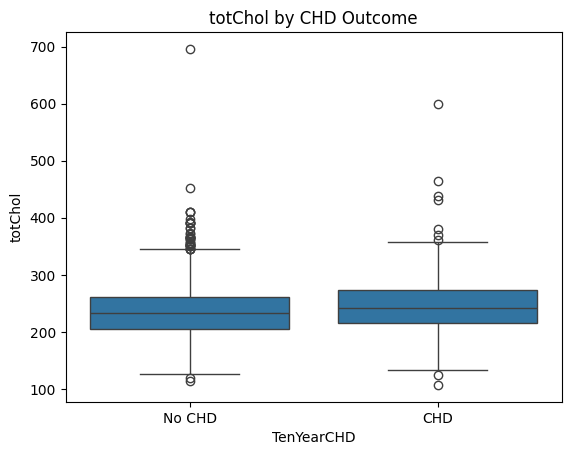

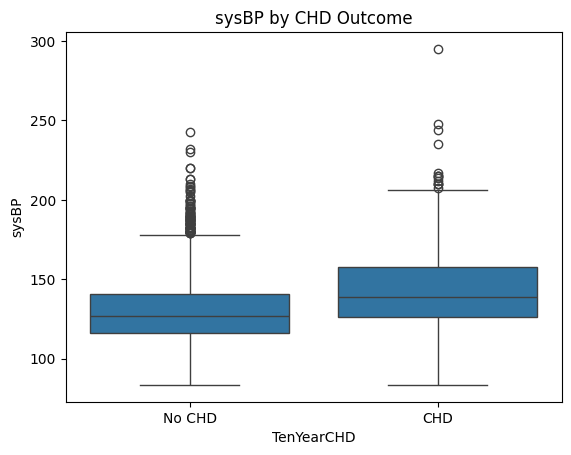

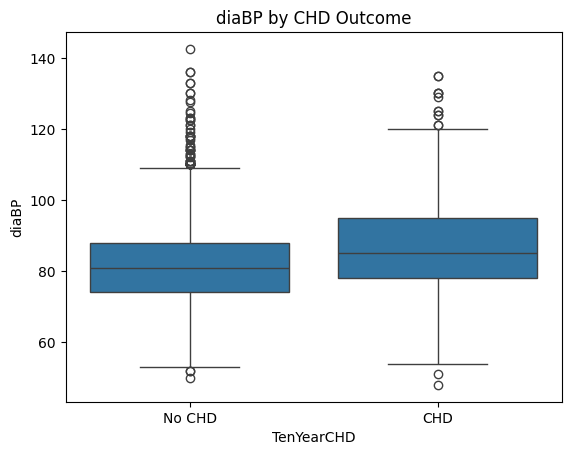

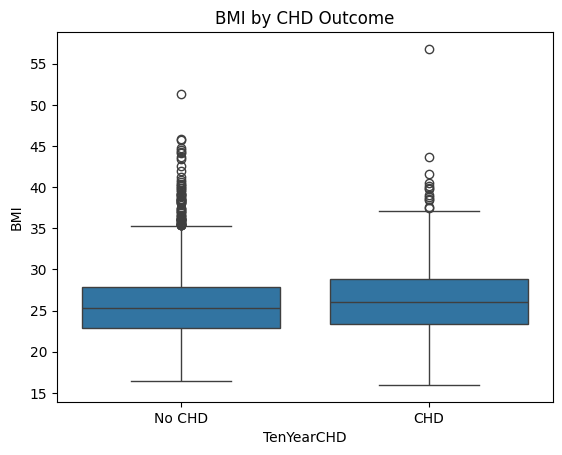

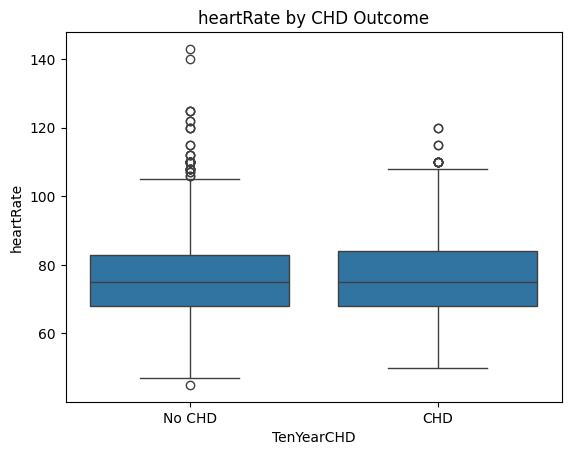

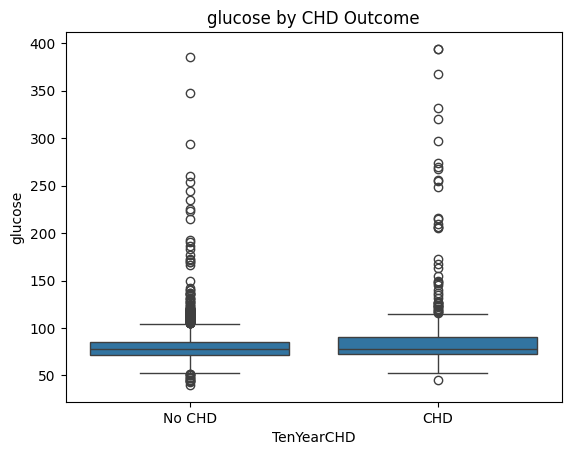

In [37]:
for col in continuous_vars:
    plt.figure()
    sns.boxplot(x='TenYearCHD', y=col, data=df_clean)
    plt.title(f'{col} by CHD Outcome')
    plt.xticks([0, 1], ['No CHD', 'CHD'])
    plt.show()

# Split the Dataset into Train/Test Sets

In [38]:
X = df_clean.drop(columns=['id', 'TenYearCHD'])
y = df_clean['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handling Outliers (Winsorization)

In [39]:
outlier_cols = ['cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for col in outlier_cols:
    lower = df_clean[col].quantile(0.01)
    upper = df_clean[col].quantile(0.99)
    df_clean[col] = np.clip(df_clean[col], lower, upper)

# Select Features

In [40]:
selected_features = [
    'age', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
    'prevalentHyp', 'prevalentStroke', 'diabetes',
    'totChol', 'sysBP', 'BMI', 'glucose'
]

# Prepare Data with Selected Features

In [41]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Scale the Features

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Convert the scaled data back into DataFrame with the same feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_selected.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_selected.columns)

# Train Logistic Regression Model

In [49]:
log_reg = LogisticRegression(max_iter=3000, random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, random_state=42)

# Predict Probabilities

In [50]:
y_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

# Find Optimal Threshold using Precision-Recall Curve

In [51]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print("Best Threshold:", best_threshold)
print("F1 Score at Best Threshold:", best_f1)
print("Precision:", precisions[best_index])
print("Recall:", recalls[best_index])

Best Threshold: 0.50673439784913
F1 Score at Best Threshold: 0.41904718113424444
Precision: 0.30985915492957744
Recall: 0.6470588235294118


# Evaluate the model with default threshold

In [53]:
y_pred = (y_probs >= 0.5).astype(int)
print("=== Default Threshold (0.5) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))


=== Default Threshold (0.5) ===
Accuracy: 0.7153392330383481
Precision: 0.29777777777777775
Recall: 0.6568627450980392
F1 Score: 0.40978593272171254
ROC AUC: 0.7250476579520697


# Evaluate the model with optimal threshold

In [54]:
y_pred_optimal = (y_probs >= best_threshold).astype(int)

print("\n=== Optimal Threshold (~{:.3f}) ===".format(best_threshold))
print("Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("Precision:", precision_score(y_test, y_pred_optimal))
print("Recall:", recall_score(y_test, y_pred_optimal))
print("F1 Score:", f1_score(y_test, y_pred_optimal))
print("ROC AUC:", roc_auc_score(y_test, y_probs))


=== Optimal Threshold (~0.507) ===
Accuracy: 0.7300884955752213
Precision: 0.30985915492957744
Recall: 0.6470588235294118
F1 Score: 0.41904761904761906
ROC AUC: 0.7250476579520697


# Coefficients Interpretation

In [55]:
coefficients = pd.Series(log_reg.coef_[0], index=selected_features)
coefficients = coefficients.sort_values(key=abs, ascending=False)
print(coefficients)

age                0.499124
sysBP              0.335887
cigsPerDay         0.234647
sex                0.224590
glucose            0.129914
totChol            0.127687
is_smoking         0.113375
prevalentHyp       0.104962
diabetes           0.062251
prevalentStroke    0.058810
BPMeds             0.016015
BMI                0.006957
dtype: float64


# Odds Ratios Interpretation

In [56]:
odds_ratios = coefficients.apply(lambda x: round(np.exp(x), 2))
print(odds_ratios)

age                1.65
sysBP              1.40
cigsPerDay         1.26
sex                1.25
glucose            1.14
totChol            1.14
is_smoking         1.12
prevalentHyp       1.11
diabetes           1.06
prevalentStroke    1.06
BPMeds             1.02
BMI                1.01
dtype: float64


# Conclusion

The final logistic regression model was effective in identifying CHD risk factors and performed well despite class imbalance. Key drivers of risk included age, systolic blood pressure, and smoking behavior. With a balanced trade-off between recall and precision, and interpretable coefficients, this model provides a strong foundation for early CHD risk screening.